<a href="https://colab.research.google.com/github/celina-velazquez/ADS-504/blob/main/Assignment_Guide_4_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import tarfile
from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder,StandardScaler, Normalizer
#from sklearn.metrics import confusion_matrix, accuracy_score,plot_confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import SGDClassifier
from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bootstrap_point632_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=matplotlib.MatplotlibDeprecationWarning)

**2 Linear Classification**

Install the package mlextend: http://rasbt.github.io/mlxtend/installation/
Next, you will do a few exercises to visualize the difference between the different linear classifiers.
Generate classification data using make_classification from sklearn.datasets:
`X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,random_state=1, n_clusters_per_class=1)`

Use SGDClassifier to train classifiers using different loss functions: log, hinge, and perceptron. Visualize
the trained classifiers using `plot_decision_regions(X, y, clf=model, legend=2)` from
the mlextend package. Plot the decision region for each of the three loss functions: a sample plot
for hinge loss appears below.

In [ ]:
!pip install mlxtend

ERROR: Operation cancelled by user


In [2]:
# Model sits here
X, y = make_classification(
    n_features=2,           # Number of features per sample
    n_redundant=0,          # No redundant features
    n_informative=2,        # Both features are informative
    random_state=1,         # Reproducible results
    n_clusters_per_class=1  # One cluster per class
)

**SGD Classifier - Log Loss**

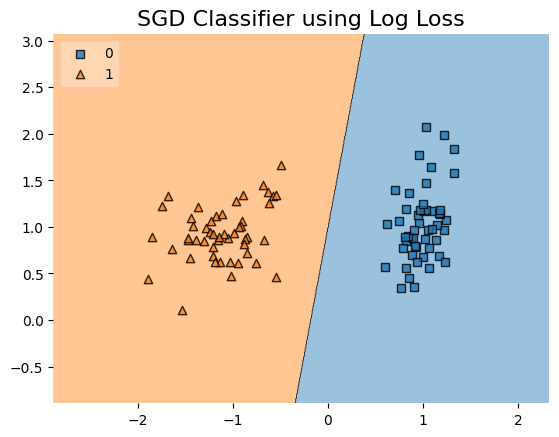

In [3]:
sgdclf_log = SGDClassifier(loss='log_loss').fit(X, y)
# Plot graph using instruction above
plot_decision_regions(X, y, clf=sgdclf_log, legend=2)
plt.title('SGD Classifier using Log Loss', size=16)
plt.show()

**SGD Classifier - Hinge Loss**

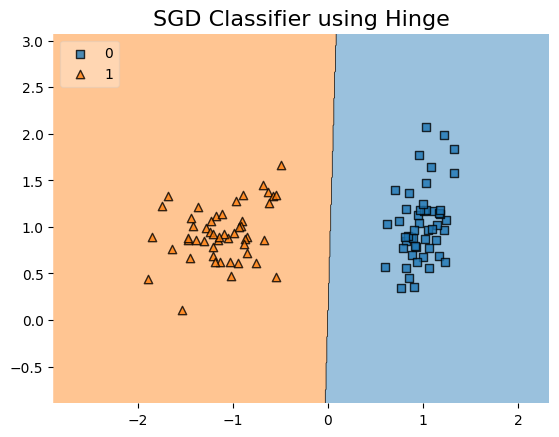

In [4]:
sgdclf_hinge = SGDClassifier(loss='hinge').fit(X, y)
# Plot graph using instruction above
plot_decision_regions(X, y, clf=sgdclf_hinge, legend=2)
plt.title('SGD Classifier using Hinge', size=16)
plt.show()

**SGD Classifier - Perceptron**

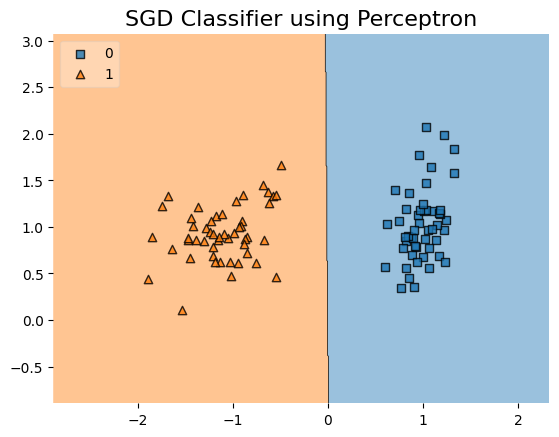

In [5]:
sgdclf_perc = SGDClassifier(loss='perceptron').fit(X, y)
# Plot graph using instruction above
plot_decision_regions(X, y, clf=sgdclf_perc, legend=2)
plt.title('SGD Classifier using Perceptron', size=16)
plt.show()

Now, create a larger classification dataset. You will use cross_val_score from scikit-learn and
compare this to bootstrap_scores from mlextend.
Set up the simulated data as follows:

`X, y = make_classification(n_samples=10000,n_features=20, n_redundant=0, n_informative=20,random_state=1,n_clusters_per_class=1)`

With your classifier in a variable called model (using SGDClassifier, as before), you can get the
accuracies as follows:

```
scores = cross_val_score(model, X, y, cv=5,scoring=scoring)
bootstrap_scores = bootstrap_point632_score(model, X, y, method='oob')
```

Create a table with the average of each cross-validation score and the average of the bootstrap
scores.

In [6]:
X, y = make_classification(n_samples=10000,n_features=20, n_redundant=0, n_informative=20,random_state=1,n_clusters_per_class=1)

In [7]:
# Here is a recommanded loop to create models
loss_f = ['log_loss', 'hinge', 'perceptron']
sgdclfs = [SGDClassifier(loss=loss).fit(X, y) for loss in loss_f]
scores_list = []
avg_list = []
for i, loss in enumerate(loss_f):
  model = sgdclfs[i]
  cv = cross_val_score(model, X, y, cv=5,scoring='accuracy')
  bs = bootstrap_point632_score(model, X, y, method='oob')
  scores_list.append({'model': loss, 'cv': cv, 'bs': bs})
  avg_list.append({'model': loss, 'Average Cross Validation': cv.mean(), 'Average Bootstrap': bs.mean()})

**Table of Average cross-validation/bootstrap scores**

In [8]:
pd.DataFrame(avg_list)

,model,Average Cross Validation,Average Bootstrap
0,log_loss,0.9051,0.902978
1,hinge,0.8916,0.895117
2,perceptron,0.8737,0.876275


/tmp/ipython-input-9-2192838935.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


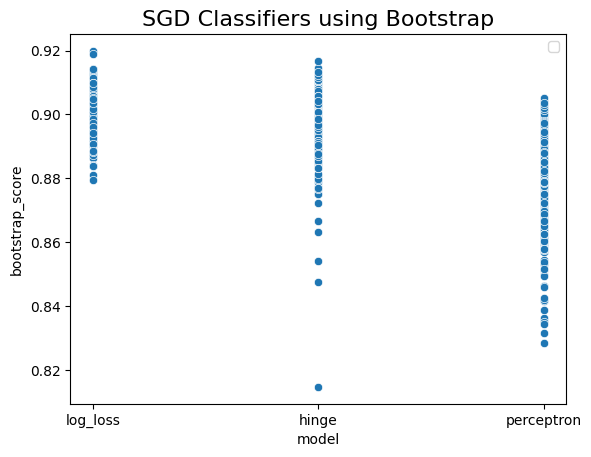

In [9]:
scores_df = pd.DataFrame(scores_list)

# Reshape the data for plotting individual bootstrap scores
plot_data = []
for index, row in scores_df.iterrows():
    model = row['model']
    for score in row['bs']:
        plot_data.append({'model': model, 'bootstrap_score': score})

plot_df = pd.DataFrame(plot_data)

#Use sns to plot hinge, log and perceptron. Remember they are all stored in scores_list['bs']
sns.scatterplot(data=plot_df, x="model", y="bootstrap_score")

plt.title('SGD Classifiers using Bootstrap', size=16)
plt.legend()
plt.show()

Finally, you will look at the importance of setting the regularization parameter. Create a database
with only two informative features:

`X, y = make_classification(n_samples=1000,n_features=2000, n_redundant=0, n_informative=2,random_state=1, n_clusters_per_class=1)`

Train a regularized classifier using ‘log’ as the loss function. Try both types of regularization ‘l1’
and ‘l2’ and sweep alpha over a range from: [0.0001,0.001,0.01,0.1,1,10,100,1000]. Use fivefold
cross-validation to measure accuracy. Create a table of accuracy indexed by alpha, and use this
table to plot the accuracy for both types of regularization. Your plot should look like this:

In [10]:
X, y = make_classification(n_samples=1000,n_features=2000, n_redundant=0, n_informative=2,random_state=1, n_clusters_per_class=1)

In [14]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
results = []
for a in alphas:
  l1clf = SGDClassifier(loss=loss, penalty='l1', alpha=a).fit(X, y) #Classifier with loss='log', penalty='l1', alpha=a, Then fit it on X and y
  l2clf = SGDClassifier(loss=loss, penalty='l2', alpha=a).fit(X, y) #Classifier with loss='log', penalty='l2', alpha=a, Then fit it on X and y
  l1cv = cross_val_score(l1clf, X, y, cv=5,scoring='accuracy') # Compute cross_val_score for l1clf, cv=5, scoring='accuracy' and mean
  l2cv = cross_val_score(l2clf, X, y, cv=5,scoring='accuracy') # Compute cross_val_score for l2clf, cv=5, scoring='accuracy' and mean
  results.append({'alpha': a, 'log L1': l1cv, 'log L2': l2cv})

**Accuracy Table by alpha value**

In [22]:
df = pd.DataFrame(results)
df['log L1'] = df['log L1'].apply(lambda x: x.mean())
df['log L2'] = df['log L2'].apply(lambda x: x.mean())
reg_df = df
display(reg_df)

,alpha,log L1,log L2
0,0.0001,0.662,0.653
1,0.0010,0.650,0.671
2,0.0100,0.713,0.647
3,0.1000,0.891,0.586
4,1.0000,0.501,0.606
5,10.0000,0.499,0.522
6,100.0000,0.501,0.501
7,1000.0000,0.501,0.499


**L1/L2 Regularization Accuracy Plot**

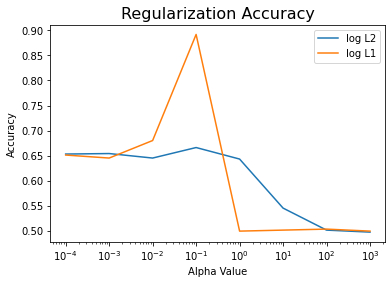

In [ ]:
# Use sns.lineplot for reg_df['alpha'] vs reg_df['log L2']
# Use sns.lineplot for reg_df['alpha'] vs reg_df['log L1']
# Add  appropriate legend and title
plt.show()

**3 Large Scale Linear Classification**
Next, you will use data from a dataset of movie reviews. Unzip the data in aclImdb_v1.tar.

There are several formats of data here, but one simple way to load the data into python is to load
the files individually into a python list, and then use tfidfVectorizer to convert the reviews into bag
of words feature files. Make sure to use pd.DataFrame.sparse.from_spmatrix to make a dataframe
from the word features.
Now, you will use fivefold cross-validation to look at the effect of the regularization penalty on
accuracy. You should be able to simply adapt your code from the earlier section with simulated
data to work on this real data. Note that due to the larger size of this text data, this section will
take several minutes or more to run.

for alpha in [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]: for penalty in [‘l1’,‘l2’]

**3.1 Download Dataset**

https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Since you run the assignment on Google Colab, you don't need to bother extracting all the text
files from the tarball. The following cells just reads all the filenames in a dataframe and you will have
7
code iterating the training and test files, reading the text into a list and appending labels into a
dataframe and the dataframes are constructed.

In [ ]:
import urllib.request
# Download tar.gz file
urllib.request.urlretrieve('https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz', 'aclImdb_v1.tar.gz')

('aclImdb_v1.tar.gz', <http.client.HTTPMessage at 0x7fb0e2662f50>)

In [ ]:
tar = tarfile.open("aclImdb_v1.tar.gz", "r:gz")
file_df = pd.DataFrame([m.name for m in tar.getmembers()], columns=['filename'])
# Paths
train_neg = 'aclImdb/train/neg/'
train_pos = 'aclImdb/train/pos/'
test_neg = 'aclImdb/test/neg/'
test_pos = 'aclImdb/test/pos/'

**Training Dataset**

In [ ]:
# This part of code creates train data
# Running this part takes quite some time
files = file_df[file_df['filename'].str.startswith(train_neg)]['filename'].tolist()
neglist = []
for file in files:
  f = tar.extractfile(file)
  if f is not N one:
    neglist.append(f.read().decode("utf-8"))
files = file_df[file_df['filename'].str.startswith(train_pos)]['filename'].tolist()
poslist = []
for file in files:
  f = tar.extractfile(file)
  if f is not None:
    poslist.append(f.read().decode("utf-8"))
train_neg_df = pd.DataFrame(list(zip(neglist, np.zeros(len(neglist)))),columns=['text', 'labels'])
train_pos_df = pd.DataFrame(list(zip(poslist, np.ones(len(poslist)))),columns=['text', 'labels'])
training = pd.concat([train_neg_df, train_pos_df], ignore_index=True)

In [ ]:
training.head()

**Test Dataset**

In [ ]:
# Use similar strategy to create testing data

In [ ]:
testing.head()

**3.2 Vectorizer - bag of words**

In [ ]:
vectorizer = TfidfVectorizer()
spmat = vectorizer.fit_transform(training['text'])
feat_names = vectorizer.get_feature_names()
Xtrain = pd.DataFrame.sparse.from_spmatrix(spmat, columns=feat_names)
ytrain = training['labels']

**SGD Classifier - Log Loss L1 Regularization**

In [ ]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
results = []
for a in alphas:
  l1clf = #Create SGDClassifier with loss of 'log', penalty of 'l1' and proper alpha=a then fit it on (Xtrain, ytrain)
  print('Finished training, alpha=%f' % a)
  l1cv = #Create cross_val_score with l1clf for Xtrain and  ytrain with cv=5 'accuracy' as scoring='accuracy' it is good to define n_jobs to make it faster and compute the mean at the end
  print('Finished 5-fold CV, alpha=%f' % a)
  results # append 'alpha' and 'log L1'
l1_acc = pd.DataFrame(results)

**SGD Classifier - Log Loss L2 Regularization**

In [ ]:
# Repeat above analysis for L2
l2_acc = pd.DataFrame(results)

**L1/L2 Accuracy Plot**

In [ ]:
# Create an appropriate plot of L1/L2. rmember to put legend and proper title